# Description
Train and test the following models for the QuickDraw Dataset:
1. Direct downsampling of images to 4D vector + a single digital layer for classification
2. Use a digital linear layer to encode images to 4D vector + a single linear digital layer for classification
3. Use a 2-layer nonlinear neural network with sigmoid nonlinear function to encode images to 4D vector + a single linear digital layer for classification

# Load Libraries

In [2]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms

# Dataloaders

In [3]:
class GT_QuickDraw_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.data = torch.tensor(data_import, dtype = torch.float32)
        self.targets = torch.tensor(label_import, dtype = torch.long)
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.targets)
        
    def __getitem__(self, idx):
        data = self.data[idx]
        
        if self.transform:
             data = self.transform(self.data[idx].unsqueeze(0))
            
        return data, self.targets[idx]

In [4]:
""" Prepare data loaders """

data = np.load('./Quickdraw_GT_images_April_7.npz')

train_np = data['train_data']
train_labels = data['train_labels']

train_idx = []
val_idx = []
np.random.seed(42)
for l in np.unique(train_labels):
    class_idx = (train_labels == l).nonzero()[0]
    np.random.shuffle(class_idx)
    train_idx.append(class_idx[:250])
    val_idx.append(class_idx[250:])
train_idx = np.array(train_idx).flatten()
val_idx = np.array(val_idx).flatten()

val_np = train_np[val_idx,:,:]
val_labels = train_labels[val_idx]
train_np = train_np[train_idx,:,:]
train_labels = train_labels[train_idx]
test_np = data['test_data']
test_labels = data['test_labels']

transforms_input = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x/190)])

transforms_input_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.025, 0.025), scale=(0.96, 1.04)), \
                                         transforms.Lambda(lambda x: x.view(-1)), \
                                         transforms.Lambda(lambda x: x)])

kwargs = {}

""" Customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(len(train_idx))), \
                                              batch_size=256, drop_last=False)
val_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(len(val_idx))), \
                                              batch_size=1000, drop_last=False)
test_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(test_np.shape[0])), \
                                             batch_size=1000, drop_last=False)

""" input image loaders """
train_loader_input = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_np, train_labels, transforms_input), \
    batch_sampler=train_sampler, **kwargs)

val_loader_input = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(val_np, val_labels, transforms_input), \
    batch_sampler=val_sampler, **kwargs)

test_loader_input = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(test_np, test_labels, transforms_input), \
    batch_sampler=test_sampler, **kwargs)

train_loader_input_downsampled = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_np.reshape(-1,2,20,2,20).mean(axis=(2,4)), train_labels, transforms_input), \
    batch_sampler = train_sampler, **kwargs)

val_loader_input_downsampled = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(val_np.reshape(-1,2,20,2,20).mean(axis=(2,4)), val_labels, transforms_input), \
    batch_sampler = val_sampler, **kwargs)

test_loader_input_downsampled = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(test_np.reshape(-1,2,20,2,20).mean(axis=(2,4)), test_labels, transforms_input), \
    batch_sampler = test_sampler, **kwargs)

In [5]:
print(next(enumerate(train_loader_input))[1][0].shape)
print(next(enumerate(val_loader_input))[1][0].shape)
print(next(enumerate(test_loader_input))[1][0].shape)
print(next(enumerate(train_loader_input_downsampled))[1][0].shape)
print(next(enumerate(val_loader_input_downsampled))[1][0].shape)
print(next(enumerate(test_loader_input_downsampled))[1][0].shape)

torch.Size([256, 1600])
torch.Size([500, 1600])
torch.Size([505, 1600])
torch.Size([256, 4])
torch.Size([500, 4])
torch.Size([505, 4])


# NN Definitions

In [6]:
""" Definition of neural network structure """

class perceptron(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fc1 = nn.Linear(Nunits[0], 10)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

class digitalLinear(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fc1 = nn.Linear(Nunits[0], Nunits[1])
        self.fc2 = nn.Linear(Nunits[1], 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
class digitalMLP(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fc1 = nn.Linear(Nunits[0], Nunits[1])
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(Nunits[1], Nunits[2])
        self.fc3 = nn.Linear(Nunits[2], 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [7]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[0.0]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define train and test functions

In [7]:
def train(epoch, model, optimizer, criterion, train_loader0, norm0=1):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data/norm0)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            
#     accuracy = 100.0 * correct/len(train_loader0.dataset)
#     print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0, norm0=1):
    model.eval()
    test_loss = 0
    correct = 0
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            outputs = model(data/norm0)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
    
    if epoch%100 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

    return test_loss, accuracy

# Check input images

In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


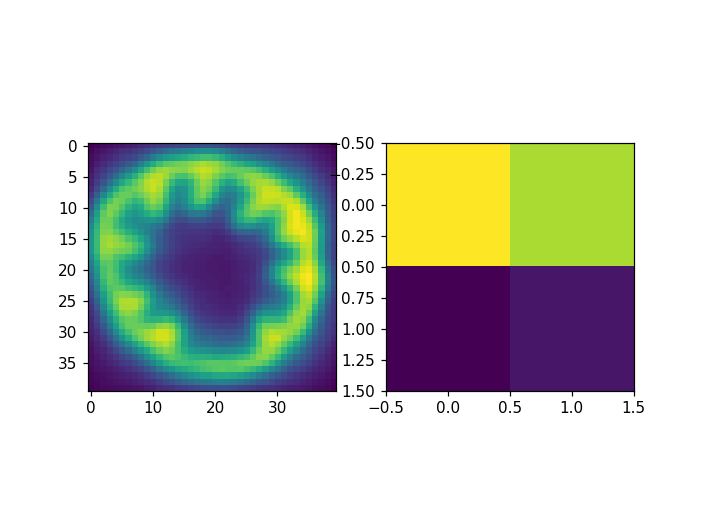

In [14]:
import matplotlib.pyplot as plt

#train_data = GT_MNIST_Dataset(train_np, train_labels, transforms_distort)
#train_data0 = GT_MNIST_Dataset(train_np, train_labels, transforms_validation)
idx = 60
fig, axes = plt.subplots(1,2)
axes[0].imshow(train_np[1,:].reshape(40,-1))
axes[1].imshow(train_np.reshape(-1,2,20,2,20).mean(axis=(2,4))[1,:].reshape(2,-1))
#print(train_data0[idx][1])

# Training loops

In [10]:
model = digitalMLP([1600, 36, 4])

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    model.cuda() # transfer the model from cpu to gpu

# Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2E-4, betas=(0.999, 0.999), weight_decay=0e-4)

# Loop around epoches
for epoch in range(1, 3000):
    train(epoch, model, optimizer, criterion, train_loader_input)
    loss, accu = test(epoch, model, criterion, val_loader_input)


Test set: Epoch 100, Average loss: 1.4784, Accuracy: 285/500(57%)


Test set: Epoch 200, Average loss: 1.1292, Accuracy: 317/500(63%)


Test set: Epoch 300, Average loss: 0.9419, Accuracy: 337/500(67%)


Test set: Epoch 400, Average loss: 0.8568, Accuracy: 357/500(71%)


Test set: Epoch 500, Average loss: 0.8070, Accuracy: 367/500(73%)


Test set: Epoch 600, Average loss: 0.7662, Accuracy: 372/500(74%)


Test set: Epoch 700, Average loss: 0.7405, Accuracy: 377/500(75%)


Test set: Epoch 800, Average loss: 0.7278, Accuracy: 384/500(77%)


Test set: Epoch 900, Average loss: 0.7283, Accuracy: 387/500(77%)


Test set: Epoch 1000, Average loss: 0.7348, Accuracy: 387/500(77%)


Test set: Epoch 1100, Average loss: 0.7429, Accuracy: 391/500(78%)


Test set: Epoch 1200, Average loss: 0.7576, Accuracy: 389/500(78%)


Test set: Epoch 1300, Average loss: 0.7738, Accuracy: 385/500(77%)


Test set: Epoch 1400, Average loss: 0.7939, Accuracy: 388/500(78%)


Test set: Epoch 1500, Average loss: 0.8204

# Load trained models and test

## Direct downsampling

In [11]:
model = perceptron([4,])
model_ckpt = torch.load("./Direct_downsampling.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.fc1.weight.data = model_state_dict['digifc.weight']
model.fc1.bias.data = model_state_dict['digifc.bias']
# model.load_state_dict(model_state_dict)

In [12]:
import matplotlib.pyplot as plt

model.cpu()
B = next(enumerate(test_loader_input_downsampled))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(238) tensor(47.1287)


## Digital linear

In [11]:
model = digitalLinear([1600,4])
model_ckpt = torch.load("./Digital_linear.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [12]:
import matplotlib.pyplot as plt

model.cpu()
B = next(enumerate(test_loader_input))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(375) tensor(74.2574)


## Digital MLP

In [14]:
model = digitalMLP([1600, 36, 4])
model_ckpt = torch.load("./Digital_nonlinear.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [15]:
import matplotlib.pyplot as plt

model.cpu()
B = next(enumerate(test_loader_input))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(415) tensor(82.1782)


In [16]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
